In [317]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
np.set_printoptions(suppress=True)
import pandas as pd

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier


from sklearn.preprocessing import Imputer, Normalizer, scale, StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.feature_selection import RFECV
from sklearn.metrics import classification_report

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns

from interval import Interval

import pandas_profiling
%matplotlib inline
mpl.style.use('ggplot')
sns.set_style('white')
pylab.rcParams['figure.figsize'] = 8, 6

# 加载数据

helper functions

In [3]:
def plot_histograms( df , variables , n_rows , n_cols ):
    fig = plt.figure( figsize = ( 16 , 12 ) )
    for i, var_name in enumerate( variables ):
        ax=fig.add_subplot( n_rows , n_cols , i+1 )
        df[ var_name ].hist( bins=10 , ax=ax )
        ax.set_title( 'Skew: ' + str( round( float( df[ var_name ].skew() ) , ) ) ) # + ' ' + var_name ) #var_name+" Distribution")
        ax.set_xticklabels( [] , visible=False )
        ax.set_yticklabels( [] , visible=False )
    fig.tight_layout()  # Improves appearance a bit.
    plt.show()

def plot_distribution( df , var , target , **kwargs ):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , hue=target , aspect=4 , row = row , col = col )
    facet.map( sns.kdeplot , var , shade= True )
    facet.set( xlim=( 0 , df[ var ].max() ) )
    facet.add_legend()

def plot_categories( df , cat , target , **kwargs ):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , row = row , col = col )
    facet.map( sns.barplot , cat , target )
    facet.add_legend()

def plot_correlation_map( df ):
    corr = df.corr()
    _ , ax = plt.subplots( figsize =( 12 , 10 ) )
    cmap = sns.diverging_palette( 220 , 10 , as_cmap = True )
    _ = sns.heatmap(
        corr, 
        cmap = cmap,
        square=True, 
        cbar_kws={ 'shrink' : 1 }, 
        ax=ax, 
        annot = True, 
        annot_kws = { 'fontsize' : 12 }
    )

def describe_more( df ):
    var = [] ; l = [] ; t = []
    for x in df:
        var.append( x )
        l.append( len( pd.value_counts( df[ x ])))
        t.append( df[ x ].dtypes )
    levels = pd.DataFrame( { 'Variable' : var , 'Levels' : l , 'Datatype' : t } )
    levels.sort_values( by = 'Levels' , inplace = True )
    return levels

def plot_variable_importance( X , y ):
    tree = DecisionTreeClassifier( random_state = 99 )
    tree.fit( X , y )
    plot_model_var_imp( tree , X , y )
    
def plot_model_var_imp( model , X , y ):
    imp = pd.DataFrame( 
        model.feature_importances_  , 
        columns = [ 'Importance' ] , 
        index = X.columns 
    )
    imp = imp.sort_values( [ 'Importance' ] , ascending = True )
    imp[ : 10 ].plot( kind = 'barh' )
    print (model.score( X , y ))
    

In [4]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

full = train.append(test, ignore_index=True)
titanic = full[:891]
del train, test
print(f"Datasets: {full.shape} titanic: {titanic.shape}")
titanic.head(10)

Datasets: (1309, 12) titanic: (891, 12)


Age Cabin Embarked     Fare  \
0  22.0   NaN        S   7.2500   
1  38.0   C85        C  71.2833   
2  26.0   NaN        S   7.9250   
3  35.0  C123        S  53.1000   
4  35.0   NaN        S   8.0500   
5   NaN   NaN        Q   8.4583   
6  54.0   E46        S  51.8625   
7   2.0   NaN        S  21.0750   
8  27.0   NaN        S  11.1333   
9  14.0   NaN        C  30.0708   

                                                Name  Parch  PassengerId  \
0                            Braund, Mr. Owen Harris      0            1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...      0            2   
2                             Heikkinen, Miss. Laina      0            3   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)      0            4   
4                           Allen, Mr. William Henry      0            5   
5                                   Moran, Mr. James      0            6   
6                            McCarthy, Mr. Timothy J      0            7   
7                     Palsson, Master. Gosta Leonard      1            8   
8  Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)      2            9   
9                Nasser, Mrs. Nicholas (Adele Achem)      0           10   

   Pclass     Sex  SibSp  Survived            Ticket  
0       3    male      1       0.0         A/5 21171  
1       1  female      1       1.0          PC 17599  
2       3  female      0       1.0  STON/O2. 3101282  
3       1  female      1       1.0            113803  
4       3    male      0       0.0            373450  
5       3    male      0       0.0            330877  
6       1    male      0       0.0             17463  
7       3    male      3       0.0            349909  
8       3  female      0       1.0            347742  
9       2  female      1       1.0            237736

In [5]:
titanic.describe()

Age        Fare       Parch  PassengerId      Pclass  \
count  714.000000  891.000000  891.000000   891.000000  891.000000   
mean    29.699118   32.204208    0.381594   446.000000    2.308642   
std     14.526497   49.693429    0.806057   257.353842    0.836071   
min      0.420000    0.000000    0.000000     1.000000    1.000000   
25%     20.125000    7.910400    0.000000   223.500000    2.000000   
50%     28.000000   14.454200    0.000000   446.000000    3.000000   
75%     38.000000   31.000000    0.000000   668.500000    3.000000   
max     80.000000  512.329200    6.000000   891.000000    3.000000   

            SibSp    Survived  
count  891.000000  891.000000  
mean     0.523008    0.383838  
std      1.102743    0.486592  
min      0.000000    0.000000  
25%      0.000000    0.000000  
50%      0.000000    0.000000  
75%      1.000000    1.000000  
max      8.000000    1.000000

## 整体数据

In [6]:
full.profile_report()

In [18]:
full[891:].profile_report()

# 数据预感受 

## 查看相关性

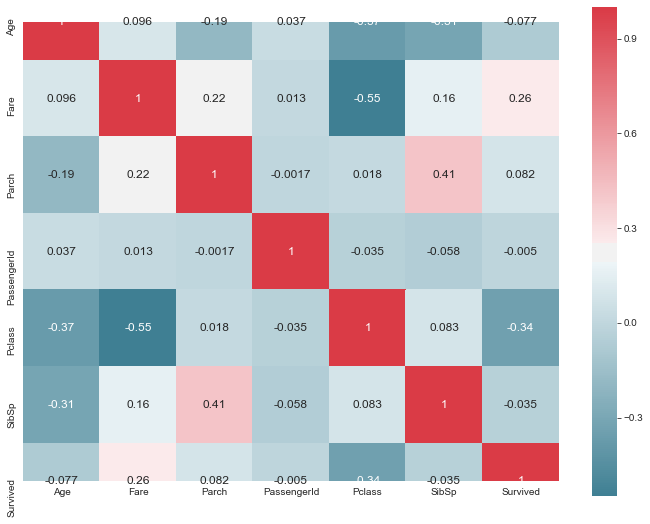

In [13]:
plot_correlation_map(titanic)

## 概率分布

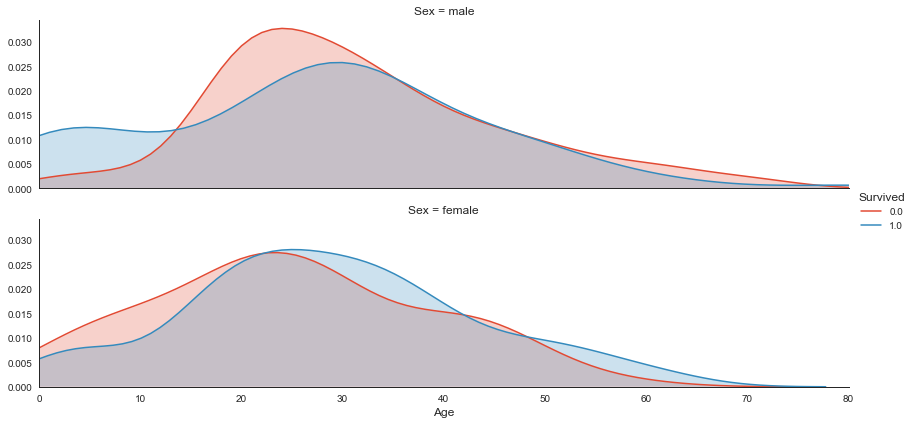

In [14]:
plot_distribution(titanic, var='Age', target='Survived', row='Sex')

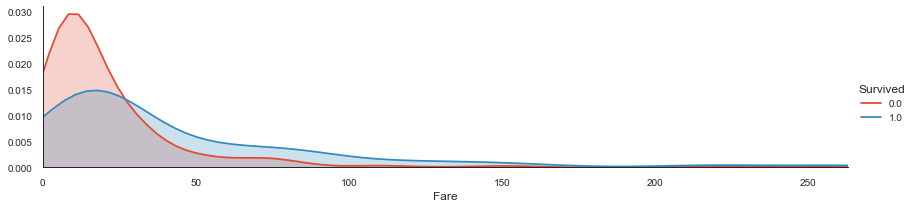

In [349]:
titanic_ = titanic.drop(titanic[titanic.Fare > 500].index, axis=0)
plot_distribution(titanic_, var='Fare', target='Survived')

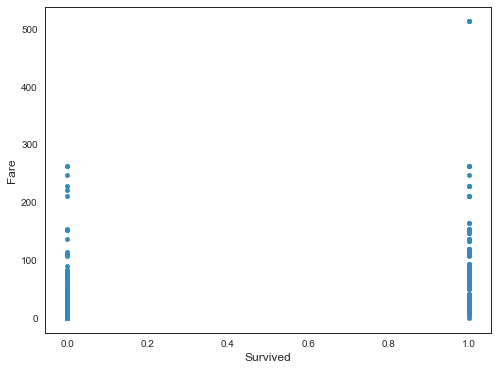

In [254]:
titanic.plot(kind='scatter', x='Survived', y='Fare')

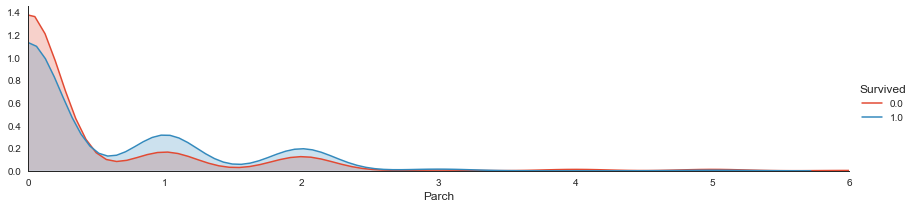

In [17]:
plot_distribution(titanic, var='Parch', target='Survived')

## 类别存活分布

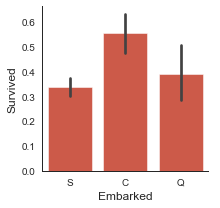

In [22]:
plot_categories(titanic, cat='Embarked', target='Survived')

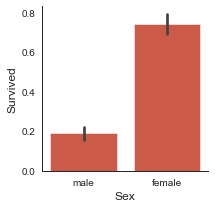

In [19]:
plot_categories(titanic, cat='Sex', target='Survived')

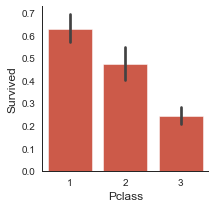

In [23]:
plot_categories(titanic, cat='Pclass', target='Survived')

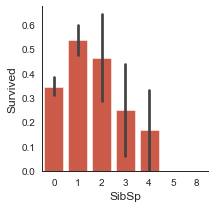

In [24]:
plot_categories(titanic, cat='SibSp', target='Survived')

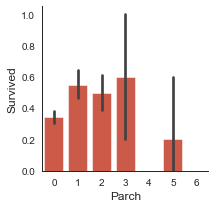

In [25]:
plot_categories(titanic, cat='Parch', target='Survived')

# 数据处理

## 类别型特征，独热编码 -- 性别，登船位置

In [76]:
sex = pd.Series(np.where(full.Sex=='male', 1, 0), name='Sex')

In [77]:
embaked = pd.get_dummies(full.Embarked, prefix='Embarked')
embaked.head()

Embarked_C  Embarked_Q  Embarked_S
0           0           0           1
1           1           0           0
2           0           0           1
3           0           0           1
4           0           0           1

In [78]:
pclass = pd.get_dummies(full.Pclass, prefix='Pclass')
pclass.head()

Pclass_1  Pclass_2  Pclass_3
0         0         0         1
1         1         0         0
2         0         0         1
3         1         0         0
4         0         0         1

## 平均值填充缺失值 -- 年龄，船票价格

数值离散化处理

In [79]:
imputed = pd.DataFrame()
# imputed['Age_scale'] = scale(full.Age.fillna(full.Age.mean()))
# imputed['Fare_scale'] = scale(full.Fare.fillna(full.Fare.mean()))
imputed['Age'] = full.Age.fillna(full.Age.mean())
imputed['Fare'] = full.Fare.fillna(full.Fare.mean())
imputed.head()

Age     Fare
0  22.0   7.2500
1  38.0  71.2833
2  26.0   7.9250
3  35.0  53.1000
4  35.0   8.0500

In [11]:
pd.cut(full.Age, bins=[0, 16, 32, 48, 64, 81]).value_counts()

(16, 32]    524
(32, 48]    269
(0, 16]     134
(48, 64]    106
(64, 81]     13
Name: Age, dtype: int64

In [12]:
pd.cut(full.Fare, 5).value_counts()

(-0.512, 102.466]     1224
(102.466, 204.932]      46
(204.932, 307.398]      34
(409.863, 512.329]       4
(307.398, 409.863]       0
Name: Fare, dtype: int64

In [80]:
imputed.Age[(imputed.Age > 0) & (imputed.Age <= 16)] = 0
imputed.Age[(imputed.Age > 16) & (imputed.Age <= 32)] = 1
imputed.Age[(imputed.Age > 32) & (imputed.Age <= 48)] = 2
imputed.Age[(imputed.Age > 48) & (imputed.Age <= 64)] = 3
imputed.Age[(imputed.Age > 64) & (imputed.Age <= 80)] = 4

In [81]:
imputed.head()

Age     Fare
0  1.0   7.2500
1  2.0  71.2833
2  1.0   7.9250
3  2.0  53.1000
4  2.0   8.0500

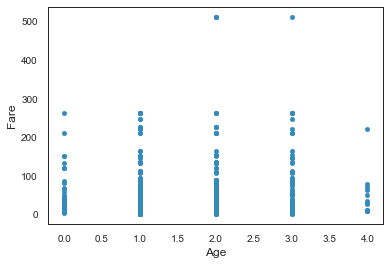

In [82]:
imputed.plot(kind='scatter',x='Age', y='Fare')

# 特征工程

## 从乘客名字获取特征信息

In [83]:
title = pd.DataFrame()
title['Title'] = full.Name.map(lambda name: name.split(',')[1].split('.')[0].strip())

In [84]:
Title_Dictionary = { "Capt":       "Officer",
                    "Col":        "Officer",
                    "Major":      "Officer",
                    "Jonkheer":   "Royalty",
                    "Don":        "Royalty",
                    "Sir" :       "Royalty",
                    "Dr":         "Officer",
                    "Rev":        "Officer",
                    "the Countess":"Royalty",
                    "Dona":       "Royalty",
                    "Mme":        "Mrs",
                    "Mlle":       "Miss",
                    "Ms":         "Mrs",
                    "Mr" :        "Mr",
                    "Mrs" :       "Mrs",
                    "Miss" :      "Miss",
                    "Master" :    "Master",
                    "Lady" :      "Royalty"}

In [85]:
title['Title'] = title.Title.map(Title_Dictionary)

In [86]:
title = pd.get_dummies(title.Title)

In [87]:
title.tail()

Master  Miss  Mr  Mrs  Officer  Royalty
1304       0     0   1    0        0        0
1305       0     0   0    0        0        1
1306       0     0   1    0        0        0
1307       0     0   1    0        0        0
1308       1     0   0    0        0        0

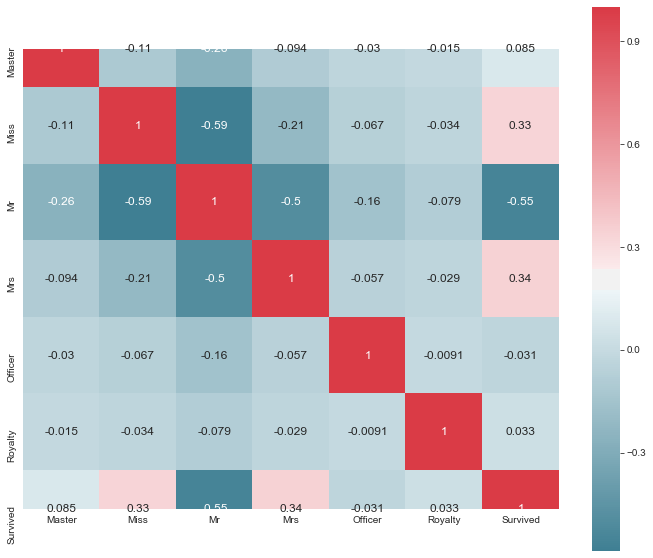

In [252]:
plot_correlation_map(pd.concat([title, full.Survived], axis=1))

## 从舱位等级提取特征信息

In [88]:
cabin = pd.DataFrame()
cabin['Cabin'] = full.Cabin.fillna('U')
cabin['Cabin'] = cabin['Cabin'].map(lambda c: c[0])
cabin = pd.get_dummies(cabin['Cabin'], prefix='Cabin')
cabin.head()

Cabin_A  Cabin_B  Cabin_C  Cabin_D  Cabin_E  Cabin_F  Cabin_G  Cabin_T  \
0        0        0        0        0        0        0        0        0   
1        0        0        1        0        0        0        0        0   
2        0        0        0        0        0        0        0        0   
3        0        0        1        0        0        0        0        0   
4        0        0        0        0        0        0        0        0   

   Cabin_U  
0        1  
1        0  
2        1  
3        0  
4        1

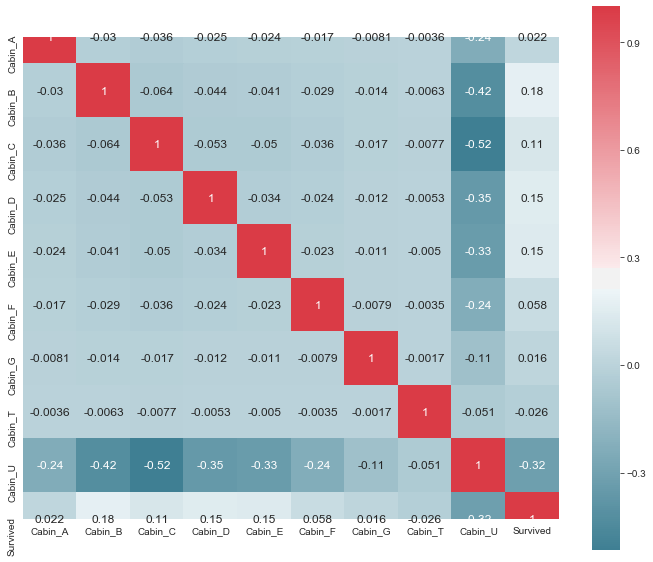

In [253]:
plot_correlation_map(pd.concat([cabin, full.Survived], axis=1))

## 从船票提取信息

In [89]:
def clean_ticket(ticket):
    ticket = ticket.replace('.','')
    ticket = ticket.replace('/','')
    ticket = ticket.split()
    ticket = map(lambda t: t.strip(), ticket)
    ticket = list(filter(lambda t: not t.isdigit(), ticket))
    if len(ticket) > 0:
        return ticket[0]
    else:
        return 'XXX'
ticket = pd.DataFrame()

ticket['Ticket'] = full.Ticket.map(clean_ticket)
ticket = pd.get_dummies(ticket.Ticket, prefix='Ticket')
ticket.head()

Ticket_A  Ticket_A4  Ticket_A5  Ticket_AQ3  Ticket_AQ4  Ticket_AS  \
0         0          0          1           0           0          0   
1         0          0          0           0           0          0   
2         0          0          0           0           0          0   
3         0          0          0           0           0          0   
4         0          0          0           0           0          0   

   Ticket_C  Ticket_CA  Ticket_CASOTON  Ticket_FC  ...  Ticket_SOTONO2  \
0         0          0               0          0  ...               0   
1         0          0               0          0  ...               0   
2         0          0               0          0  ...               0   
3         0          0               0          0  ...               0   
4         0          0               0          0  ...               0   

   Ticket_SOTONOQ  Ticket_SP  Ticket_STONO  Ticket_STONO2  Ticket_STONOQ  \
0               0          0             0              0              0   
1               0          0             0              0              0   
2               0          0             0              1              0   
3               0          0             0              0              0   
4               0          0             0              0              0   

   Ticket_SWPP  Ticket_WC  Ticket_WEP  Ticket_XXX  
0            0          0           0           0  
1            0          0           0           0  
2            0          0           0           0  
3            0          0           0           1  
4            0          0           0           1  

[5 rows x 37 columns]

## 从家庭成员提取信息

In [90]:
family = pd.DataFrame()
family['FamilySize'] = full.Parch + full.SibSp + 1
family['Family_Single'] = family['FamilySize'].map(lambda s: 1 if s==1 else 0)
family['Family_Small'] = family['FamilySize'].map(lambda s: 1 if 2 <=s <=4 else 0)
family['Family_Large'] = family['FamilySize'].map(lambda s: 1 if s >=5 else 0)
family.head()

FamilySize  Family_Single  Family_Small  Family_Large
0           2              0             1             0
1           2              0             1             0
2           1              1             0             0
3           2              0             1             0
4           1              1             0             0

# 特征选取，数据重装

In [308]:
full_X = pd.concat([imputed, sex, full.Pclass, title, family.FamilySize, 
                    combine.Female_Class, combine.Age_Class,
                   combine.Child_Old], axis=1)
full_X.tail()

Age      Fare  Sex  Pclass  Master  Miss  Mr  Mrs  Officer  Royalty  \
1304  1.0    8.0500    1       3       0     0   1    0        0        0   
1305  2.0  108.9000    0       1       0     0   0    0        0        1   
1306  2.0    7.2500    1       3       0     0   1    0        0        0   
1307  1.0    8.0500    1       3       0     0   1    0        0        0   
1308  1.0   22.3583    1       3       1     0   0    0        0        0   

      FamilySize  Female_Class  Age_Class  Child_Old  
1304           1           0.0        3.0        0.0  
1305           1           1.0        2.0        0.0  
1306           1           0.0        6.0        0.0  
1307           1           0.0        3.0        0.0  
1308           3           0.0        3.0        0.0

## 组合特征

In [291]:
combine = pd.concat([full_X, full.Survived], axis=1)
combine.head()

Age     Fare  Sex  Pclass  Master  Miss  Mr  Mrs  Officer  Royalty  \
0  1.0   7.2500    1       3       0     0   1    0        0        0   
1  2.0  71.2833    0       1       0     0   0    1        0        0   
2  1.0   7.9250    0       3       0     1   0    0        0        0   
3  2.0  53.1000    0       1       0     0   0    1        0        0   
4  2.0   8.0500    1       3       0     0   1    0        0        0   

   FamilySize  Female_Class  Age_Class  Survived  
0           2           0.0        3.0       0.0  
1           2           1.0        2.0       1.0  
2           1           0.0        3.0       1.0  
3           2           1.0        2.0       1.0  
4           1           0.0        6.0       0.0

### 高级别舱位女性

In [292]:
combine.loc[(combine.Sex == 0) & (combine.Pclass < 3), 'Female_Class'] = 1

In [293]:
combine.Female_Class.fillna(0,axis=0, inplace=True)

In [294]:
combine['Age_Class'] = combine.Age * combine.Pclass

In [295]:
combine.head()

Age     Fare  Sex  Pclass  Master  Miss  Mr  Mrs  Officer  Royalty  \
0  1.0   7.2500    1       3       0     0   1    0        0        0   
1  2.0  71.2833    0       1       0     0   0    1        0        0   
2  1.0   7.9250    0       3       0     1   0    0        0        0   
3  2.0  53.1000    0       1       0     0   0    1        0        0   
4  2.0   8.0500    1       3       0     0   1    0        0        0   

   FamilySize  Female_Class  Age_Class  Survived  
0           2           0.0        3.0       0.0  
1           2           1.0        2.0       1.0  
2           1           0.0        3.0       1.0  
3           2           1.0        2.0       1.0  
4           1           0.0        6.0       0.0

### 儿童和老人

In [296]:
combine[combine.Age > 3].Survived.value_counts()

0.0    10
1.0     1
Name: Survived, dtype: int64

In [297]:
combine.loc[(combine.Age == 0) | (combine.Age == 4), 'Child_Old'] = 1
combine.Child_Old.fillna(0, axis=0, inplace=True)
combine.head()

Age     Fare  Sex  Pclass  Master  Miss  Mr  Mrs  Officer  Royalty  \
0  1.0   7.2500    1       3       0     0   1    0        0        0   
1  2.0  71.2833    0       1       0     0   0    1        0        0   
2  1.0   7.9250    0       3       0     1   0    0        0        0   
3  2.0  53.1000    0       1       0     0   0    1        0        0   
4  2.0   8.0500    1       3       0     0   1    0        0        0   

   FamilySize  Female_Class  Age_Class  Survived  Child_Old  
0           2           0.0        3.0       0.0        0.0  
1           2           1.0        2.0       1.0        0.0  
2           1           0.0        3.0       1.0        0.0  
3           2           1.0        2.0       1.0        0.0  
4           1           0.0        6.0       0.0        0.0

In [286]:
combine[combine.Age < 1][combine.Sex == 1].Survived.value_counts()

0.0    29
1.0    22
Name: Survived, dtype: int64

### 青年男士

In [290]:
combine[combine.Sex == 1][combine.Age == 1].Survived.value_counts()

0.0    294
1.0     56
Name: Survived, dtype: int64

# 数据分组

## 剔除`Fare`过高的值

In [309]:
train_valid_X = full_X[:891]
train_valid_X.drop(train_valid_X[train_valid_X.Fare > 500].index, axis=0, inplace=True)
titanic.drop(titanic[titanic.Fare > 500].index, axis=0, inplace=True)
train_valid_y = titanic.Survived.astype(int)
train_valid_X.shape, train_valid_y.shape

((888, 14), (888,))

In [310]:
test_X = full_X[891:]
train_X, valid_X, train_y, valid_y = train_test_split(train_valid_X, train_valid_y, train_size=.7)
print(full_X.shape, train_X.shape, valid_X.shape, train_y.shape, valid_y.shape, test_X.shape)

(1309, 14) (621, 14) (267, 14) (621,) (267,) (418, 14)


In [311]:
train_X.tail()

Age      Fare  Sex  Pclass  Master  Miss  Mr  Mrs  Officer  Royalty  \
709  1.0   15.2458    1       3       1     0   0    0        0        0   
660  3.0  133.6500    1       1       0     0   0    0        1        0   
725  1.0    8.6625    1       3       0     0   1    0        0        0   
316  1.0   26.0000    0       2       0     0   0    1        0        0   
46   1.0   15.5000    1       3       0     0   1    0        0        0   

     FamilySize  Female_Class  Age_Class  Child_Old  
709           3           0.0        3.0        0.0  
660           3           0.0        3.0        0.0  
725           1           0.0        3.0        0.0  
316           2           1.0        2.0        0.0  
46            2           0.0        3.0        0.0

# 找出最重要的特征 

0.9550561797752809


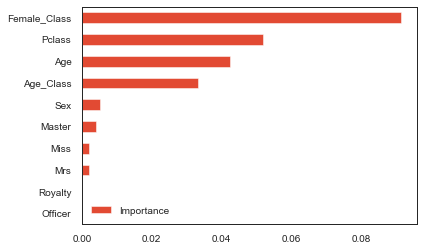

In [234]:
plot_variable_importance(train_X, train_y)

# 选择合适模型
[集成学习过程参考 -- 然而效果并没有比简单的逻辑回归更好，结果在79%](https://www.kaggle.com/yassineghouzam/titanic-top-4-with-ensemble-modeling/comments)

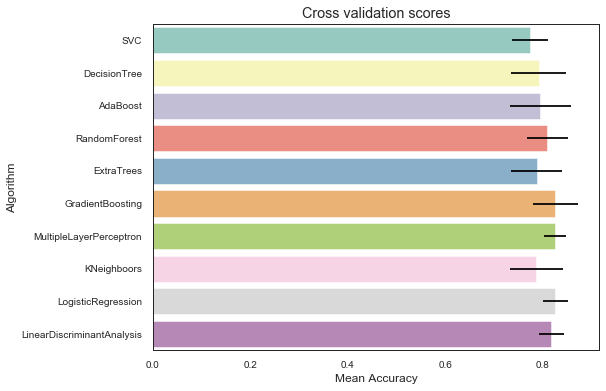

In [325]:
random_state = 42
kfold = StratifiedKFold(n_splits=10)

models = []
models.append(SVC(random_state=random_state))
models.append(DecisionTreeClassifier(random_state=random_state))
models.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),
             random_state=random_state, learning_rate=.1))
models.append(RandomForestClassifier(random_state=random_state))
models.append(ExtraTreesClassifier(random_state=random_state))
models.append(GradientBoostingClassifier(random_state=random_state))
models.append(MLPClassifier(random_state=random_state))
models.append(KNeighborsClassifier())
models.append(LogisticRegression(random_state=random_state))
models.append(LinearDiscriminantAnalysis())

cv_results = []
for model in models:
    cv_results.append(cross_val_score(model, train_X, train_y, scoring='accuracy', cv=kfold))
    
cv_means = []
cv_stds = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_stds.append(cv_result.std())

cv_res = pd.DataFrame({"CrossValMeans":cv_means,
                       "CrossValerrors": cv_stds,
                       "Algorithm":["SVC","DecisionTree",
                                    "AdaBoost",
                                    "RandomForest","ExtraTrees",
                                    "GradientBoosting",
                                    "MultipleLayerPerceptron",
                                    "KNeighboors",
                                    "LogisticRegression",
                                    "LinearDiscriminantAnalysis"]})

g = sns.barplot("CrossValMeans","Algorithm",data = cv_res, palette="Set3",orient = "h",**{'xerr':cv_stds})
g.set_xlabel("Mean Accuracy")
g = g.set_title("Cross validation scores")

## 选择集成学习的模型并微调

In [330]:
DTC = DecisionTreeClassifier()

adaDTC = AdaBoostClassifier(DTC, random_state=7)

ada_param_grid = {"base_estimator__criterion" : ["gini", "entropy"],
              "base_estimator__splitter" :   ["best", "random"],
              "algorithm" : ["SAMME","SAMME.R"],
              "n_estimators" :[1,2],
              "learning_rate":  [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3,1.5]}

gsadaDTC = GridSearchCV(adaDTC,param_grid = ada_param_grid, cv=kfold, scoring="accuracy", verbose = 1)

gsadaDTC.fit(train_X,train_y)

ada_best = gsadaDTC.best_estimator_

gsadaDTC.best_score_

Fitting 10 folds for each of 112 candidates, totalling 1120 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1120 out of 1120 | elapsed:    9.7s finished


0.8083735909822867

In [331]:
ExtC = ExtraTreesClassifier()

## Search grid for optimal parameters
ex_param_grid = {"max_depth": [None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini"]}


gsExtC = GridSearchCV(ExtC,param_grid = ex_param_grid, cv=kfold, scoring="accuracy", verbose = 1)

gsExtC.fit(train_X,train_y)

ExtC_best = gsExtC.best_estimator_

# Best score
gsExtC.best_score_

Fitting 10 folds for each of 54 candidates, totalling 540 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    6.3s
[Parallel(n_jobs=4)]: Done 376 tasks      | elapsed:   28.6s
[Parallel(n_jobs=4)]: Done 540 out of 540 | elapsed:   42.3s finished


0.8276972624798712

In [334]:
RFC = RandomForestClassifier()

## Search grid for optimal parameters
rf_param_grid = {"max_depth": [None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini"]}


gsRFC = GridSearchCV(RFC,param_grid = rf_param_grid, cv=kfold, scoring="accuracy", verbose = 1)

gsRFC.fit(train_X,train_y)

RFC_best = gsRFC.best_estimator_

# Best score
gsRFC.best_score_

Fitting 10 folds for each of 54 candidates, totalling 540 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 540 out of 540 | elapsed:  2.3min finished


0.8341384863123994

In [335]:
GBC = GradientBoostingClassifier()
gb_param_grid = {'loss' : ["deviance"],
              'n_estimators' : [100,200,300],
              'learning_rate': [0.1, 0.05, 0.01],
              'max_depth': [4, 8],
              'min_samples_leaf': [100,150],
              'max_features': [0.3, 0.1] 
              }

gsGBC = GridSearchCV(GBC,param_grid = gb_param_grid, cv=kfold, scoring="accuracy", verbose = 1)

gsGBC.fit(train_X,train_y)

GBC_best = gsGBC.best_estimator_

# Best score
gsGBC.best_score_

Fitting 10 folds for each of 72 candidates, totalling 720 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 720 out of 720 | elapsed:  1.2min finished


0.8373590982286635

In [336]:
SVMC = SVC(probability=True)
svc_param_grid = {'kernel': ['rbf'], 
                  'gamma': [ 0.001, 0.01, 0.1, 1],
                  'C': [1, 10, 50, 100,200,300, 1000]}

gsSVMC = GridSearchCV(SVMC,param_grid = svc_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsSVMC.fit(train_X, train_y)

SVMC_best = gsSVMC.best_estimator_

# Best score
gsSVMC.best_score_

Fitting 10 folds for each of 28 candidates, totalling 280 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 144 tasks      | elapsed:    6.0s
[Parallel(n_jobs=4)]: Done 280 out of 280 | elapsed:   26.7s finished


0.8164251207729468

## 学习曲线

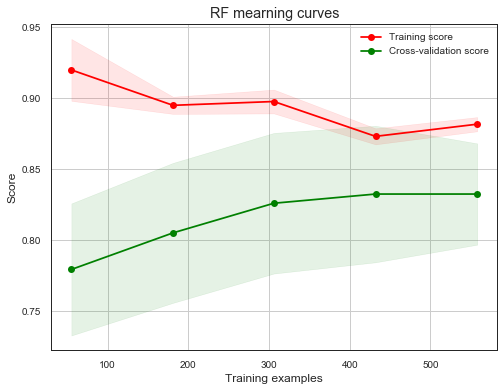

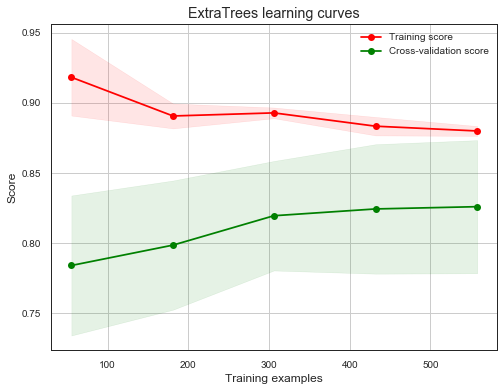

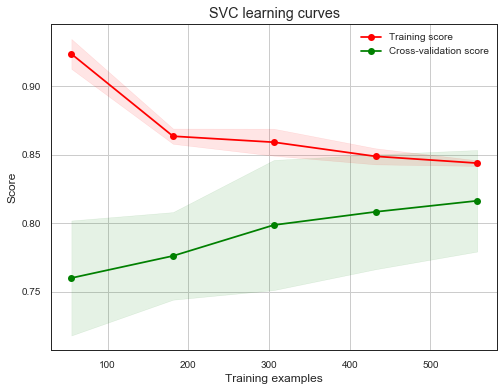

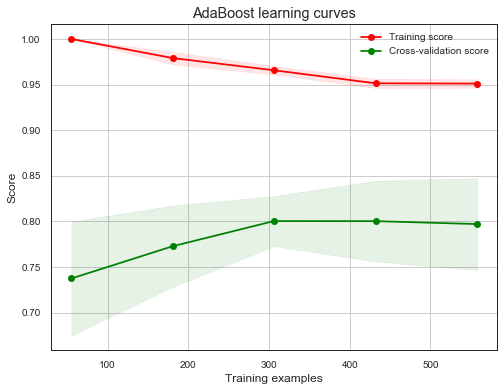

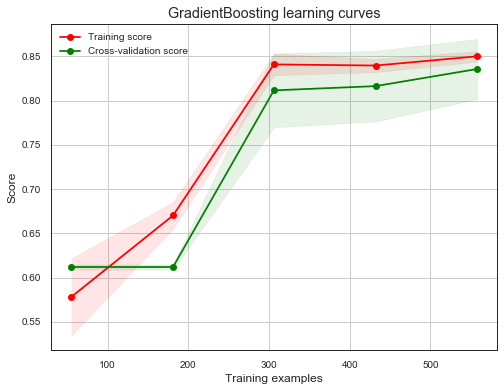

In [337]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    """Generate a simple plot of the test and training learning curve"""
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

g = plot_learning_curve(gsRFC.best_estimator_,"RF mearning curves",train_X, train_y,cv=kfold)
g = plot_learning_curve(gsExtC.best_estimator_,"ExtraTrees learning curves",train_X, train_y,cv=kfold)
g = plot_learning_curve(gsSVMC.best_estimator_,"SVC learning curves",train_X, train_y,cv=kfold)
g = plot_learning_curve(gsadaDTC.best_estimator_,"AdaBoost learning curves",train_X, train_y,cv=kfold)
g = plot_learning_curve(gsGBC.best_estimator_,"GradientBoosting learning curves",train_X, train_y,cv=kfold)

## 特征重要程度分析

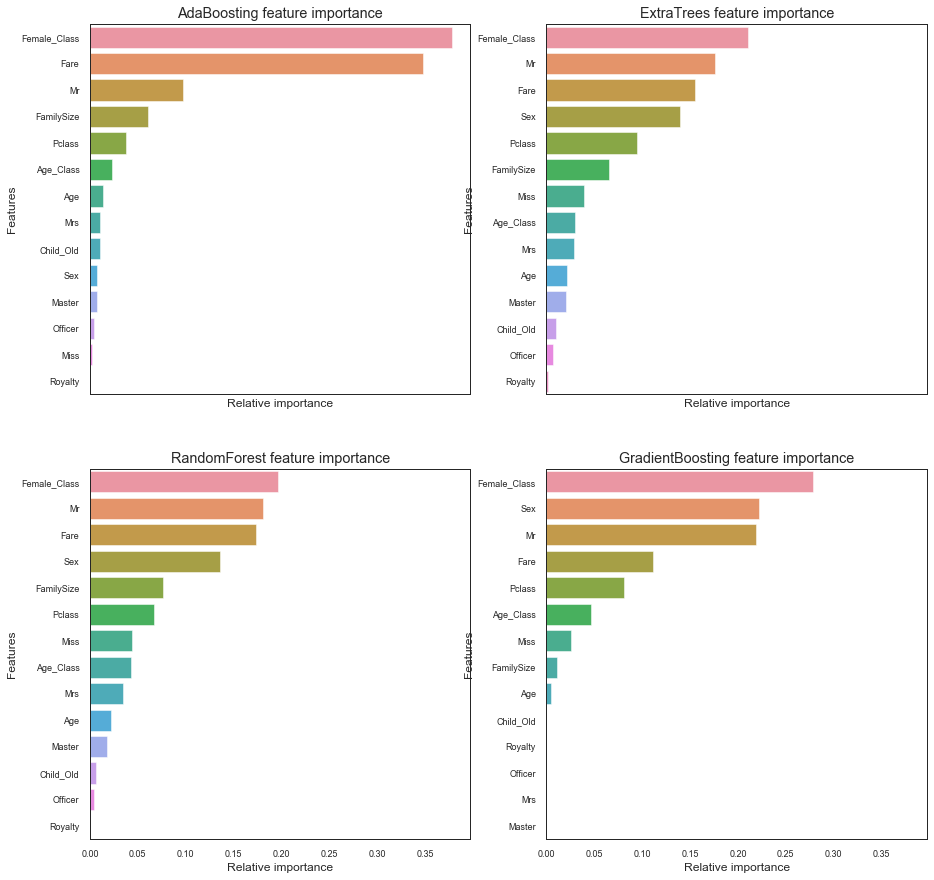

In [339]:
nrows = ncols = 2
fig, axes = plt.subplots(nrows = nrows, ncols = ncols, sharex="all", figsize=(15,15))

names_classifiers = [("AdaBoosting", ada_best),("ExtraTrees",ExtC_best),("RandomForest",RFC_best),("GradientBoosting",GBC_best)]

nclassifier = 0
for row in range(nrows):
    for col in range(ncols):
        name = names_classifiers[nclassifier][0]
        classifier = names_classifiers[nclassifier][1]
        indices = np.argsort(classifier.feature_importances_)[::-1][:40]
        g = sns.barplot(y=train_X.columns[indices][:40],x = classifier.feature_importances_[indices][:40] , orient='h',ax=axes[row][col])
        g.set_xlabel("Relative importance",fontsize=12)
        g.set_ylabel("Features",fontsize=12)
        g.tick_params(labelsize=9)
        g.set_title(name + " feature importance")
        nclassifier += 1

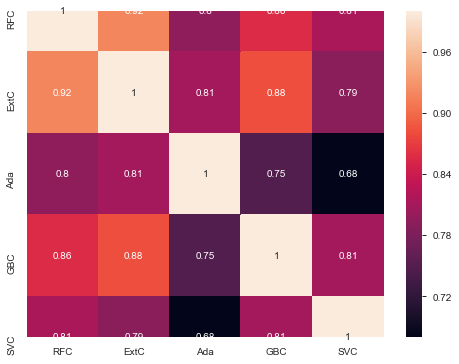

In [341]:
test_Survived_RFC = pd.Series(RFC_best.predict(test_X), name="RFC")
test_Survived_ExtC = pd.Series(ExtC_best.predict(test_X), name="ExtC")
test_Survived_SVMC = pd.Series(SVMC_best.predict(test_X), name="SVC")
test_Survived_AdaC = pd.Series(ada_best.predict(test_X), name="Ada")
test_Survived_GBC = pd.Series(GBC_best.predict(test_X), name="GBC")

# Concatenate all classifier results
ensemble_results = pd.concat([test_Survived_RFC,test_Survived_ExtC,test_Survived_AdaC,test_Survived_GBC, test_Survived_SVMC],axis=1)


g= sns.heatmap(ensemble_results.corr(),annot=True)

## 集成学习

In [342]:
votingC = VotingClassifier(estimators=[('rfc', RFC_best), ('extc', ExtC_best),
('svc', SVMC_best), ('adac',ada_best),('gbc',GBC_best)], voting='soft', n_jobs=4)

votingC = votingC.fit(train_X, train_y)

## 查看逻辑斯蒂回归验证组中分错的情况

In [351]:
model_log.fit(train_X, train_y)
model_log.score(train_X, train_y)

0.8373590982286635

In [352]:
y_pred = model_log.predict(valid_X)

In [259]:
valid_X[y_pred != valid_y].profile_report()

In [353]:
valid_X[(y_pred == 1) & (valid_y == 0)]

Age      Fare  Sex  Pclass  Master  Miss  Mr  Mrs  Officer  Royalty  \
534  1.0    8.6625    0       3       0     1   0    0        0        0   
501  1.0    7.7500    0       3       0     1   0    0        0        0   
772  3.0   10.5000    0       2       0     0   0    1        0        0   
807  1.0    7.7750    0       3       0     1   0    0        0        0   
498  1.0  151.5500    0       1       0     0   0    1        0        0   
654  1.0    6.7500    0       3       0     1   0    0        0        0   
7    0.0   21.0750    1       3       1     0   0    0        0        0   
114  1.0   14.4583    0       3       0     1   0    0        0        0   
852  0.0   15.2458    0       3       0     1   0    0        0        0   
199  1.0   13.0000    0       2       0     1   0    0        0        0   
822  2.0    0.0000    1       1       0     0   0    0        0        1   
882  1.0   10.5167    0       3       0     1   0    0        0        0   

     FamilySize  Female_Class  Age_Class  Child_Old  
534           1           0.0        3.0        0.0  
501           1           0.0        3.0        0.0  
772           1           1.0        6.0        0.0  
807           1           0.0        3.0        0.0  
498           4           1.0        1.0        0.0  
654           1           0.0        3.0        0.0  
7             5           0.0        0.0        1.0  
114           1           0.0        3.0        0.0  
852           3           0.0        0.0        1.0  
199           1           1.0        2.0        0.0  
822           1           0.0        2.0        0.0  
882           1           0.0        3.0        0.0

In [354]:
valid_X[(y_pred == 0) & (valid_y == 1)]

Age      Fare  Sex  Pclass  Master  Miss  Mr  Mrs  Officer  Royalty  \
85   2.0   15.8500    0       3       0     0   0    1        0        0   
460  2.0   26.5500    1       1       0     0   1    0        0        0   
21   2.0   13.0000    1       2       0     0   1    0        0        0   
712  2.0   52.0000    1       1       0     0   1    0        0        0   
261  0.0   31.3875    1       3       1     0   0    0        0        0   
328  1.0   20.5250    0       3       0     0   0    1        0        0   
632  1.0   30.5000    1       1       0     0   0    0        1        0   
449  3.0   30.5000    1       1       0     0   0    0        1        0   
550  1.0  110.8833    1       1       0     0   1    0        0        0   
673  1.0   13.0000    1       2       0     0   1    0        0        0   
288  2.0   13.0000    1       2       0     0   1    0        0        0   
55   1.0   35.5000    1       1       0     0   1    0        0        0   
209  2.0   31.0000    1       1       0     0   1    0        0        0   
448  0.0   19.2583    0       3       0     1   0    0        0        0   
839  1.0   29.7000    1       1       0     0   1    0        0        0   
74   1.0   56.4958    1       3       0     0   1    0        0        0   
23   1.0   35.5000    1       1       0     0   1    0        0        0   
330  1.0   23.2500    0       3       0     1   0    0        0        0   
204  1.0    8.0500    1       3       0     0   1    0        0        0   
724  1.0   53.1000    1       1       0     0   1    0        0        0   
394  1.0   16.7000    0       3       0     0   0    1        0        0   
570  3.0   10.5000    1       2       0     0   1    0        0        0   
453  3.0   89.1042    1       1       0     0   1    0        0        0   
707  2.0   26.2875    1       1       0     0   1    0        0        0   
338  2.0    8.0500    1       3       0     0   1    0        0        0   
740  1.0   30.0000    1       1       0     0   1    0        0        0   
298  1.0   30.5000    1       1       0     0   1    0        0        0   
690  1.0   57.0000    1       1       0     0   1    0        0        0   
146  1.0    7.7958    1       3       0     0   1    0        0        0   
579  1.0    7.9250    1       3       0     0   1    0        0        0   
744  1.0    7.9250    1       3       0     0   1    0        0        0   
226  1.0   10.5000    1       2       0     0   1    0        0        0   
469  0.0   19.2583    0       3       0     1   0    0        0        0   

     FamilySize  Female_Class  Age_Class  Child_Old  
85            4           0.0        6.0        0.0  
460           1           0.0        2.0        0.0  
21            1           0.0        4.0        0.0  
712           2           0.0        2.0        0.0  
261           7           0.0        0.0        1.0  
328           3           0.0        3.0        0.0  
632           1           0.0        1.0        0.0  
449           1           0.0        3.0        0.0  
550           3           0.0        1.0        0.0  
673           1           0.0        2.0        0.0  
288           1           0.0        4.0        0.0  
55            1           0.0        1.0        0.0  
209           1           0.0        2.0        0.0  
448           4           0.0        0.0        1.0  
839           1           0.0        1.0        0.0  
74            1           0.0        3.0        0.0  
23            1           0.0        1.0        0.0  
330           3           0.0        3.0        0.0  
204           1           0.0        3.0        0.0  
724           2           0.0        1.0        0.0  
394           3           0.0        3.0        0.0  
570           1           0.0        6.0        0.0  
453           2           0.0        3.0        0.0  
707           1           0.0        2.0        0.0  
338           1           0.0        6.0        0.0  
740           1 

In [232]:
rfecv = RFECV(estimator=model_log, step=1, cv=StratifiedKFold(2), scoring='accuracy')
rfecv.fit(train_X, train_y)

RFECV(cv=StratifiedKFold(n_splits=2, random_state=None, shuffle=False),
      estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                   fit_intercept=True, intercept_scaling=1,
                                   l1_ratio=None, max_iter=100,
                                   multi_class='warn', n_jobs=None,
                                   penalty='l2', random_state=None,
                                   solver='warn', tol=0.0001, verbose=0,
                                   warm_start=False),
      min_features_to_select=1, n_jobs=None, scoring='accuracy', step=1,
      verbose=0)

0.8314606741573034 0.832089552238806
Optimal number of features : 13


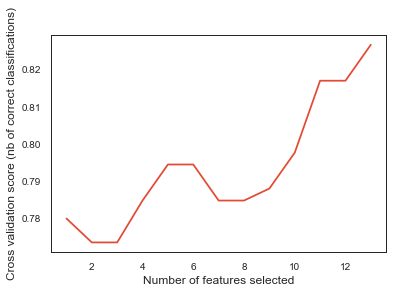

In [233]:
print(rfecv.score(train_X , train_y) , rfecv.score(valid_X , valid_y))
print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1 ) , rfecv.grid_scores_)
plt.show()

# 预测

In [344]:
test_Y = votingC.predict(test_X)
passenger_id = full[891:].PassengerId

In [345]:
test = pd.DataFrame({
    'PassengerId': passenger_id,
    'Survived': test_Y
})
test.shape

(418, 2)

In [346]:
test.head()

PassengerId  Survived
891          892         0
892          893         0
893          894         0
894          895         0
895          896         1

In [347]:
test.to_csv('titanic_pred_votingC.csv', index=False)

分数，`78%`， 待加强

# 保存模型

In [236]:
import joblib

In [237]:
joblib.dump(model_log,'model_logistic_78.pkl')
# modle = joblib.load('model.pkl')

['model_logistic_78.pkl']